In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from sic_simulator import SimulationConfig, SimulatorSIC
from visualisation import sic_plot_pdr_heatmap, sic_plot_pdr_vs_power
from data_io import sic_save_simulation, sic_make_filename

In [ ]:
if __name__ == "__main__":
    cfg = SimulationConfig(
        sample_rate=10e6,  # Samples per second
        protocol_high="802154",  # BLE or IEEE 802.15.4
        protocol_low="ble",
        ble_rate=1e6,  # 1 Mb/s or 2 Mb/s
        amplitude_high=10 ** (-6 / 20),  # Amplitude for higher-power signal (fixed)
        amplitude_low=10 ** (-7 / 20),  # Amplitude for lower-power signal (swept)
        snr_low_db=20,  # SNR in (dB) relative to the lower power generated signal
        freq_offset_range=range(-5000, 5000, 50),  # (Hz) For demodulation brute force search
        fine_step=2,  # Step size (Hz) for the fine search
        fine_window=50,  # Half-width (Hz) of the window around best coarse frequency
        payload_len_high=30,  # Bytes in high-power payload
        payload_len_low=200,  # Bytes in low-power payload
        sample_shift_range_low=(0, 1),  # Range to randomly apply fractional delays on IQ data
        sample_shift_range_high=(200, 2200),
        freq_high=None,  # Fixed frequency offset for high-power signal, if None random in freq_offset_range
        freq_low=None,  # Fixed frequency offset for low-power signal, if None random in freq_offset_range
        phase_high=None,  # Fixed phase for high-power signal, if None random
        phase_low=None,  # Fixed phase for low-power signal, if None random
        adc_bits=12,  # ADC resolution in bits
        adc_vmax=1.0,  # Maximum ADC input amplitude
        padding=500,  # Zero-pad the generated signals before adding them to ensure equal length
    )

# Single trial

In [5]:
simulator = SimulatorSIC(cfg)
simulator.simulate_single_trial(cfg.amplitude_high, cfg.amplitude_low, cfg.snr_low_db, verbose=True)

High-power signal not demodulated; trying low-power directly
received_packet_low = {'payload': array([ 46,  94,  10,  69, 215,  68, 245,  29, 138,  74, 174,  52,  36,
        35, 223,  21,  30,  12, 208, 245, 248, 111, 136, 178, 209, 150,
       103, 127, 187,  78,  40,   9, 112, 219, 216,  37,  46, 104,  65,
        51, 178,   6, 180, 173,  24, 205,  56, 101, 154, 132,   9, 189,
       155, 203,  29,  35, 195,  20,  37,  41, 103,  12,  17,   0, 178,
       199,  25, 141, 158, 243, 118, 252, 109, 180, 202, 176, 243,  63,
       138,   7,  29, 128,  83,  32, 140,   1, 183,  61, 201, 212,  21,
        98, 164, 242, 255, 123,   2,  71, 116, 250,  64,  83, 182,  73,
       123,   2, 219, 121,  60, 191,  96, 166, 242,  76, 222, 180,  48,
        87, 117,  64, 218, 173,  20, 130, 206, 200,  82, 104, 107, 150,
       181, 158,  38,  64,  42, 227, 129, 143, 214, 214,  74, 143, 166,
       150,  71,  24, 252,  48,  86, 155, 180, 249, 193, 149, 138,  92,
        52, 122, 210,  68, 121, 169,  70,

(False, False)

# Monte Carlo simulation

In [4]:
high_power_db: float = -6  # dB, around 0.707 amplitude
low_powers_db: np.ndarray = np.arange(-6, -20, -1)  # dB, up to around 0.1 amplitude
snr_lows_db: np.ndarray = np.arange(0, 15, 2)  # dB
num_trials: int = 4

pdr: np.ndarray = simulator.run_monte_carlo_parallel(
    high_power_db, low_powers_db, snr_lows_db, num_trials=num_trials
)  # Shape (2, Powers, SNRs)

Simulating: 100%|██████████| 112/112 [01:47<00:00,  1.04it/s]


# Save

In [5]:
sic_save_simulation(cfg, high_power_db, low_powers_db, snr_lows_db, num_trials, pdr, folder="../sic_simulations")

Saved simulation to ../sic_simulations/802154-30B_BLE1Mbps-200B_10Msps_4trials.npz


# Load

PDR shape: (2, 14, 8)
low_powers_db = array([ -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15, -16, -17, -18,
       -19])
snr_lows_db = array([ 0,  2,  4,  6,  8, 10, 12, 14])
(2, 14, 8)


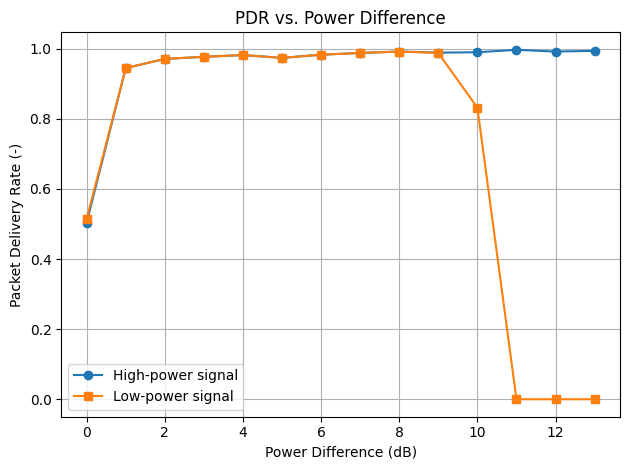

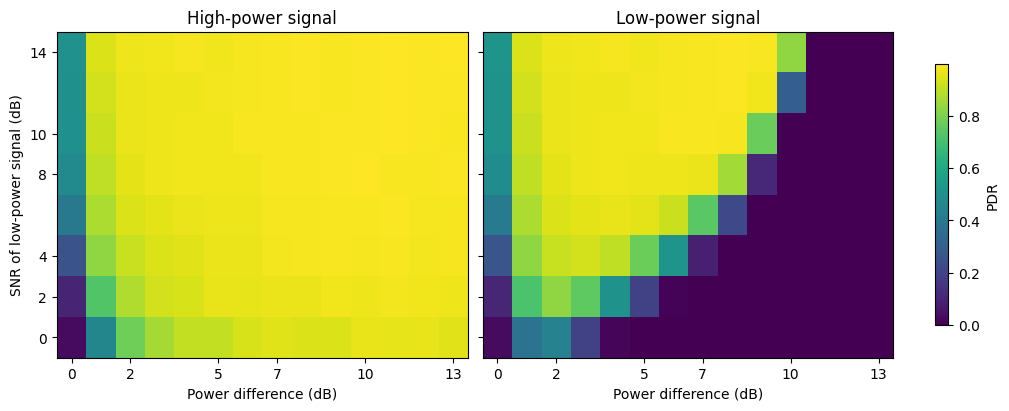

In [17]:
filename = "BLE1Mbps-200B_802154-30B_10Msps_1000trials.npz"
filename = "802154-30B_BLE1Mbps-200B_10Msps_1000trials.npz"
filename = "802154-30B_BLE1Mbps-200B_4Msps_1000trials.npz"
filename = "802154-30B_BLE1Mbps-200B_30Msps_1000trials.npz"

data = np.load(f"../sic_simulations/{filename}", allow_pickle=True)
# data = np.load(f"../sic_simulations/{sic_make_filename(cfg, 4)}", allow_pickle=True)

# Extract each parameter
high_power_db = float(data["high_power_db"])
low_powers_db = data["low_powers_db"]
snr_lows_db = data["snr_lows_db"]
num_trials = int(data["num_trials"])
pdr = data["pdr"]
cfg_dict = data["cfg"].item()  # Reconstruct the config data class from dictionary
cfg = SimulationConfig(**cfg_dict)

print("PDR shape:", pdr.shape)


print(f"{low_powers_db = }")
print(f"{snr_lows_db = }")
print(pdr.shape)
sic_plot_pdr_vs_power(high_power_db, low_powers_db, pdr[:, :, 7], figsize=None)
sic_plot_pdr_heatmap(high_power_db, low_powers_db, snr_lows_db, pdr)

low_powers_db = array([ -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15, -16, -17, -18,
       -19])
snr_lows_db = array([ 0,  2,  4,  6,  8, 10, 12, 14])
(2, 14, 8)


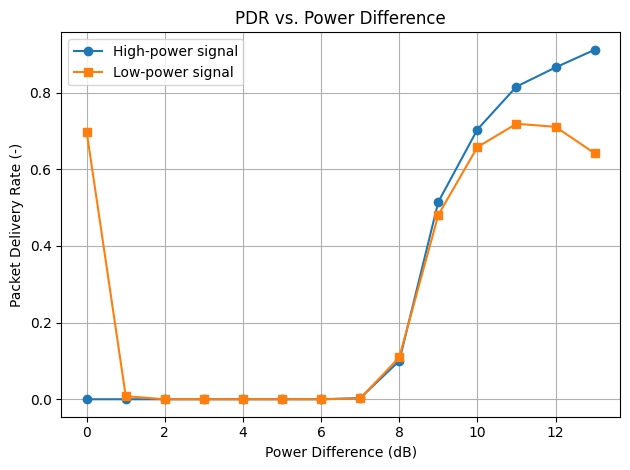

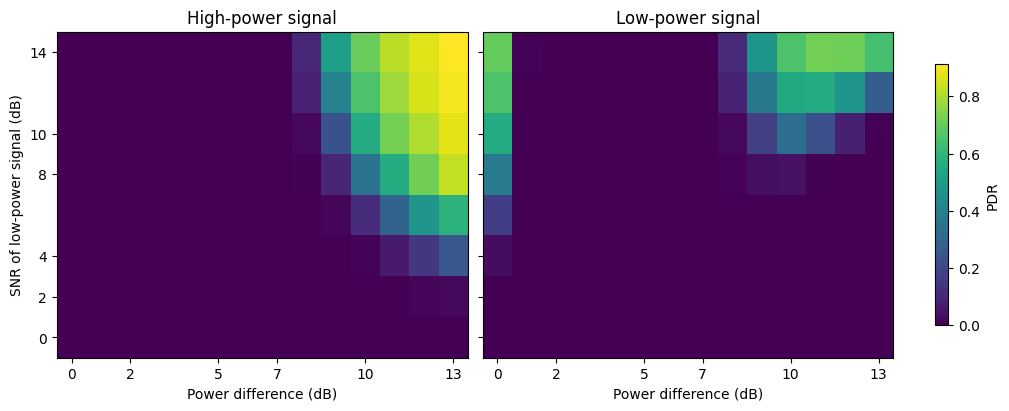